In [1]:
# Install packages
%pip install networkx
%pip install numpy
%pip install tqdm
%pip install matplotlib
%pip install simanneal 

import sys# Start writing code here...

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.6 MB/s eta 0:00:00
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
from starter import *
from anneal import *
import math
import copy, random
from collections import defaultdict, Counter
import itertools
# inp_dir = '/datasets/gdrive/170 Project/project/inputs'
# out_dir = '/datasets/gdrive/170 Project/project/outputs'
inp_dir = 'inputs'
out_dir = 'output'

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class GraphPartitioner(Annealer):
    class StateObject:
        def __init__(self, k):
            self.k = 0
            self.p = [0 for _ in range(k)]
            self.pi = [0 for _ in range(k)]
            self.norm_b = 0
            self.cost_p, self.cost_w, self.cost_k = 0, 0, 0
            self.total_cost = 0
        def get_scores(self):
            return self.cost_w, self.cost_k, self.cost_p, self.total_cost
        
    def __init__(self, Graph: nx.Graph, k):
        
        self.G = Graph
        self.num_v = len(self.G.nodes)
        self.max_p = k
        self.state = self.StateObject(self.max_p)

        ### Below are all state variables
        self.k_way_random_part() # remember to add 1 to pi at the very end so no team is assigned 0
        
        b = [self.get_b_val(i) for i in range(len(self.state.p))]
        self.state.norm_b = np.linalg.norm(b)
        
        self.state.cost_p = math.exp(70 * self.state.norm_b)
        self.compute_cost_w_initial()
        self.compute_cost_k()
        self.state.total_cost = self.state.cost_k + self.state.cost_p + self.state.cost_w

        super(GraphPartitioner, self).__init__(self.state)  # important!
    
    def get_b_val(self, i):
        return self.state.p[i]/self.num_v - 1/self.state.k

    ### Sets up the teams in G and the b vector
    def k_way_random_part(self):
        self.state.pi = np.random.randint(self.max_p, size=len(self.G.nodes)) #  partition=0 is illegal
        self.state.k = len(set(self.state.pi))

        for v in range(self.num_v):
            self.state.p[self.state.pi[v]] += 1

    def compute_cost_k(self):
        self.state.cost_k = 100 * math.exp(self.state.k * 0.5)

    def compute_cost_p_on_swap(self, i, j):
        b_i, b_j = self.get_b_val(i), self.get_b_val(j)
        new_norm_b_squared = self.state.norm_b**2 - b_i**2 - b_j**2 + (b_i-1/self.num_v)**2 + (b_j+1/self.num_v)**2
        
        if math.isclose(new_norm_b_squared, 0, abs_tol=1e-9):
            new_norm_b_squared = 0
        self.state.norm_b = new_norm_b_squared ** 0.5
        self.state.cost_p = math.exp(70 * self.state.norm_b)
    
    def compute_cost_p_from_scratch(self):
        b = [i/self.num_v - 1/self.state.k for i in self.state.p if i != 0]
        self.state.norm_b = np.linalg.norm(b)
        self.state.cost_p = math.exp(70 * self.state.norm_b)
        
    def compute_cost_p(self, new):
        pass

    def compute_cost_w_initial(self):
        for u, v in self.G.edges:
            if self.state.pi[u] == self.state.pi[v]:
                self.state.cost_w += self.G[u][v]['weight']

    def compute_cost_w(self, u, i , j):
        for v in self.G[u]:
            if self.state.pi[v] == i:
                self.state.cost_w -= self.G[u][v]['weight']
            elif self.state.pi[v] == j:
                self.state.cost_w += self.G[u][v]['weight']

    def compute_total_cost(self, v, i, j):
        ### Compute new cost_k if needed
        k_changed = False
        if self.state.p[i] == 1: 
            self.state.k -= 1
            k_changed = True
        if self.state.p[j] == 0:
            self.state.k += 1
            k_changed = True
        if k_changed:
            self.compute_cost_k()
            self.state.p[i] -= 1
            self.state.p[j] += 1
            self.compute_cost_p_from_scratch()
        else:
            self.compute_cost_p_on_swap(i, j)
            self.state.p[i] -= 1
            self.state.p[j] += 1

        self.compute_cost_w(v, i, j)
        
        self.state.pi[v] = j

        self.state.total_cost = self.state.cost_k + self.state.cost_p + self.state.cost_w
        return self.state.total_cost

    def swap_one_vertex(self):
        v = np.random.randint(self.num_v)
        i = self.state.pi[v]
        choices = [i for i in range(self.max_p)if self.state.p[i] != 0]
        if i in choices:
            choices.remove(i)
        j = choices[np.random.randint(self.state.k-1)]

        # j = 0 if i else 1
        self.compute_total_cost(v, i, j)

    def add_one(self, reverse = False):
        for v in self.G.nodes:
            self.state.pi[v] += 1 * (-1) ** reverse
    
    def get_scores(self):
        return self.state.get_scores()

    def energy(self):
        return self.state.total_cost

    def move(self):
        NUM_MOVES = 1
        # for _ in range(NUM_MOVES):
        self.swap_one_vertex()

    def apply_pi(self):
        for v in range(self.num_v):
            self.G.nodes[v]['team'] = self.state.pi[v] + 1
            
    def update(self, step, T, E, acceptance, improvement):
        pass
        # print(self.Tmax, self.Tmin)
        # if T == 0 or math.isclose(T, 0, abs_tol=1e-3):
        #     self.set_user_exit("Temp 0", "break")
        # print(T, math.isclose(T, 0, abs_tol=1e-3), self.steps, self.user_exit)
        # self.default_update(step, T, E, acceptance, improvement)
            
def apply_pi(G, pi):
    num_v = len(G.nodes)
    assert num_v == len(pi)
    max_p = max(pi)

    p = list(Counter(pi))
    p.sort()
    map_p = {p[i]:i for i in range(len(p))}
    for v in range(num_v):
        G.nodes[v]['team'] = int(map_p[pi[v]] + 1)
    return G       

In [3]:
math.isclose(5.3e-3, 0, abs_tol=1e-2)

True

In [4]:
# files = os.listdir('inputs')
# files.sort()
# results = pd.DataFrame([[x,10**10, 0] for x in files if x.endswith('.in')], columns=['name', 'score', 'k'])
# results.to_csv('best_scores.csv', index=False)

In [5]:
df = pd.read_csv('best_scores.csv')
min(df['score'])

272.8281828459045

In [6]:
def run(solver, in_file: str, out_file: str, file_name, overwrite: bool=False):
    instance = read_input(in_file)
    print(file_name)
    cost, k, pi, state = solver(instance)
    if not math.isclose(score(instance), cost):
        print(score(instance, separated=True))
        print(state.get_scores())
        return instance, pi, state
        # print(pi)
        # print([instance.nodes[v]['team'] for v in instance.nodes])
        
    r = df.index[df['name'] == file_name]
    overwrite = cost < float(df.iloc[r]['score'])
    # print(cost,float(df.iloc[r]['score']) )
    if overwrite:
        df.loc[r, 'score'] = cost
        df.loc[r, 'k'] = k
        df.to_csv('best_scores.csv', index=False)
        print(f"{str(in_file)}: cost", score(instance))
        write_output(instance, out_file, overwrite)

    return None

def save_and_plot(files, scores, output_name):
    counts, bins = np.histogram(scores)
    plt.stairs(counts, bins)
    
    scores_and_names = list(zip(files, scores))
    scores_and_names.sort()
    cat_size = len(scores)//3
    
    second = lambda x: x[1]
    large = sum(map(second, scores_and_names[:cat_size]))/cat_size
    medium = sum(map(second, scores_and_names[cat_size:cat_size*2]))/cat_size
    small =  sum(map(second, scores_and_names[cat_size*2:]))/cat_size
    
    os.makedirs('scores/' + output_name, exist_ok=True)  
    f = open('scores/' + output_name + '/avg_scores.txt', "w")
    f.write("small_avg: {0} \nmedium_avg: {1} \nlarge_avg: {2}".format(small, medium, large))
    f.close()
    
    df = pd.DataFrame(zip(files, scores), columns=['name', 'score'])
    df.to_csv('scores/' + output_name + '/out.csv')
    
from collections import Counter
def run_all(solver, in_dir, out_dir, output_name, overwrite: bool=False):
    scores = defaultdict()
    files = [x for x in os.listdir(in_dir) if x.endswith('.in')]
    # files.sort(reverse=True)
    random.shuffle(files)
    for file in tqdm(files):
        ### only run if havent done so before
        r = df.index[df['name'] == file]
        if float(df.iloc[r]['score']) >= 1000000000:
            err = run(solver, str(Path(in_dir) / file), str(Path(out_dir) / f"{file[:-len('.in')]}.out"), file, overwrite)
            if err:
                return err[2]
    return None

In [7]:
def solve(G: nx.Graph):
    NUM_ITER_OUT = 1
    NUM_ITER_IN = 1
    min_cost = 10**20
    pi = []
    best_k = 0
    best_state= None
    quit = False
    epsilon = 10**-5
    num_v = len(G.nodes)
    size_to_time = {100: 0.02, 300:0.04, 1000:0.05}
    time = size_to_time[num_v]
    
    for k in range(2,18, 2):

            # best_state = copy.deepcopy(tourney.state)
        for i in range(NUM_ITER_OUT):
            # tourney = GraphPartitioner(copy.deepcopy(G), k)
            tourney = GraphPartitioner((G), k)
            tourney.set_schedule(tourney.auto(minutes=time))
            cost = tourney.energy()
            if cost < min_cost - epsilon:
                min_cost, pi, best_k = cost, tourney.state.pi.copy(), tourney.state.k
            if cost > 2*min_cost:
                quit = True
            if quit:
                break
            for _ in range(NUM_ITER_IN):
                partitioning, cost = tourney.anneal()
                if cost > 2*min_cost:
                    quit = True
                if quit:
                    break
                if cost < min_cost - epsilon:
                    min_cost, pi, best_k = cost, tourney.state.pi.copy(), tourney.state.k
                    # best_state = copy.deepcopy(tourney.state)
        if quit:
            break
    apply_pi(G, pi)
    return min_cost, best_k, pi, best_state

In [ ]:
state = run_all(solve, 'inputs', 'outputs', output_name='sim_anneal', overwrite=True)
if state:
    print(state.get_scores())

In [8]:
G, pi, best_state, _ = run(solve, 'inputs/small181.in', 'outputs/small181.out', 'small181.in', overwrite=True)
'small181'

small181.in
25000.0 2.5
0.0 True 50000 True
25000.0 2.5
4500.0 False 50000 True
25000.0 2.5
6800.0 False 50000 True
25000.0 2.5
10000.0 False 50000 True
25000.0 2.5
15000.0 False 50000 True
25000.0 2.5
22000.0 False 50000 True
25000.0 2.5
33000.0 False 50000 True
25000.0 2.5
50000.0 False 50000 True
25000.0 2.5
75000.0 False 50000 True
25000.0 2.5
110000.0 False 50000 True
25000.0 2.5
160000.0 False 50000 True
25000.0 2.5
240000.0 False 50000 True
25000.0 2.5
160000.0 False 50000 True
25000.0 2.5
110000.0 False 50000 True
25000.0 2.5
73000.0 False 50000 True
25000.0 2.5
49000.0 False 50000 True
25000.0 2.5
33000.0 False 50000 True
25000.0 2.5
22000.0 False 50000 True
25000.0 2.5
15000.0 False 50000 True
25000.0 2.5
10000.0 False 50000 True
25000.0 2.5
6700.0 False 50000 True
25000.0 2.5
4500.0 False 50000 True
240000.0 4500.0
240000.0 False 33000 True
25000.0 2.5
0.0 True 50000 True
25000.0 2.5
4900.0 False 50000 True
25000.0 2.5
7400.0 False 50000 True
25000.0 2.5
11000.0 False 50000 

TypeError: cannot unpack non-iterable NoneType object

In [8]:
G=read_input('inputs/small181.in')
min_cost = 10**7
NUM_ITER_OUT = 1
NUM_ITER_IN = 1
min_cost = 10**20
pi = []
best_k = 0
best_state= None
quit = False
epsilon = 10**-5
num_v = len(G.nodes)
size_to_time = {100: 0.01, 300:0.04, 1000:0.05}
time = size_to_time[num_v]
for k in range(2,8, 2):
        # best_state = copy.deepcopy(tourney.state)
    for i in range(NUM_ITER_OUT):
        # tourney = GraphPartitioner(copy.deepcopy(G), k)
        tourney = GraphPartitioner((G), k)
        tourney.set_schedule(tourney.auto(minutes=time))
        cost = tourney.energy()
        if cost < min_cost - epsilon:
            min_cost, pi, best_k = cost, tourney.state.pi.copy(), tourney.state.k
        if cost > 2*min_cost:
            quit = True
        if quit:
            break
        for _ in range(NUM_ITER_IN):
            partitioning, cost = tourney.anneal()
            if cost > 2*min_cost:
                quit = True
            if quit:
                break
            if cost < min_cost - epsilon:
                min_cost, pi, best_k = cost, tourney.state.pi.copy(), tourney.state.k
                # best_state = copy.deepcopy(tourney.state)
    if quit:
        break

25000.0 2.5
0.0 True 50000 True
25000.0 2.5
1500.0 False 50000 True
25000.0 2.5
2200.0 False 50000 True
25000.0 2.5
3300.0 False 50000 True
25000.0 2.5
5000.0 False 50000 True
25000.0 2.5
7500.0 False 50000 True
25000.0 2.5
11000.0 False 50000 True
25000.0 2.5
16000.0 False 50000 True
25000.0 2.5
24000.0 False 50000 True
25000.0 2.5
36000.0 False 50000 True
25000.0 2.5
54000.0 False 50000 True
25000.0 2.5
81000.0 False 50000 True
25000.0 2.5
120000.0 False 50000 True
25000.0 2.5
180000.0 False 50000 True
25000.0 2.5
120000.0 False 50000 True
25000.0 2.5
80000.0 False 50000 True
25000.0 2.5
53000.0 False 50000 True
25000.0 2.5
35000.0 False 50000 True
25000.0 2.5
23000.0 False 50000 True
25000.0 2.5
15000.0 False 50000 True
25000.0 2.5
10000.0 False 50000 True
25000.0 2.5
6700.0 False 50000 True
25000.0 2.5
4500.0 False 50000 True
180000.0 4500.0
180000.0 False 16000 True
25000.0 2.5
0.0 True 50000 True
25000.0 2.5
43.0 False 50000 True
25000.0 2.5
64.0 False 50000 True
25000.0 2.5
96.0

In [92]:
print(best_state.norm_b)

best_state.cost_p
output = [G.nodes[v]['team'] for v in range(G.number_of_nodes())]
teams, counts = np.unique(output, return_counts=True)
print(counts)
k = np.max(teams)
b = np.linalg.norm((counts / G.number_of_nodes()) - 1 / k, 2)
print(b, (counts / G.number_of_nodes()) - 1 / k, 2)


0.19364916731032897
[10 10 10 10 10 10 10 10 10 10]
0.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 2


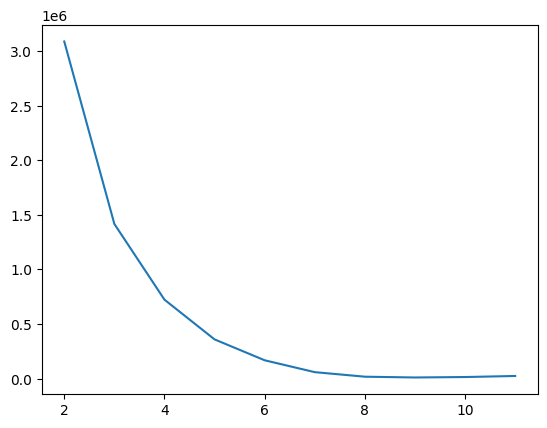

In [52]:
plt.plot([x for x,y in costs], [y for x,y in costs])

In [7]:
solve(read_input('inputs/small151.in'))

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    73.00000    1496618.52     0.00%     0.00%     0:00:04    -1:59:59 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    73.00000    1498870.83     0.00%     0.00%     0:00:01     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    67.00000     627828.60     0.00%     0.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    67.00000     636962.91     0.00%     0.00%     0:00:01     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    49.00000     358978.04     0.00%     0.00%     0:00:03    -1:59:59 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    49.00000     363157.14     0.33%     0.33%     0:00:01     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    15.00000     234632.96     0.00%     0.00%     0:00:03    -1:59:59 Temperature 

(157302.7311602446,
 12,
 array([ 0,  4, 13, 14,  2,  7, 14, 11,  5, 11,  7,  5, 12, 10,  0, 11, 10,
        13,  0,  9, 15,  5, 13,  4,  2, 13, 13,  7,  0,  2, 15,  4, 13, 14,
         4, 15, 10,  0,  4,  9,  5, 10,  4,  5, 11, 15,  2, 10, 11,  2, 15,
         5, 10,  0,  9, 15, 14, 12,  9, 13, 11, 14,  9, 10,  0, 12,  5,  7,
         7,  2, 15, 14,  7,  9, 13, 15, 11,  7,  5,  2, 15,  4,  0,  5,  9,
         7, 12, 14,  2, 10,  7,  9,  4,  0, 12,  7, 12, 13, 14, 12]),
 None)

In [7]:
G = read_input('inputs/small67.in')

In [ ]:
_, _, pi = solve(G)
validate_output(G)
visualize(G) 
score(G)

In [7]:
tar('outputs', overwrite = True)

In [90]:
G = read_input('inputs/small150.in')
tourney = GraphPartitioner(copy.deepcopy(G), 4)
# tourney.set_schedule(tourney.auto(minutes=0.02))
pi = None
for i in range(1000):
    tourney.swap_one_vertex()
pi = tourney.state.pi
apply_pi(G, pi)   
print(score(G, separated=True))
print(tourney.get_scores())
print()

{0: 0, 1: 1, 2: 2, 3: 3}
(499725, 738.905609893065, 5.55469113312566)
(499725, 738.905609893065, 5.5546911331257744, 500469.4603010262)



In [89]:
print(tourney.G == G)
[tourney.G.nodes[v]['team'] for v in range(tourney.G.number_of_nodes())]

False


KeyError: 'team'

Tmax = 25000.0  # Max (starting) temperature
Tmin = 2.5      # Min (ending) temperature
steps = 500000   # Number of iterations
updates = 1000   # Number of updates (by default an update prints to stdout)
g = read_input('test_inputs/small.in')
tourney = GraphPartitioner(g, 5)
tourney.copy_strategy = "deepcopy"